# Quest05: 네이버 영화리뷰 감성분석 도전하기!

### 평가문항에 맞춰서 작성
**1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.**  
-> 3가지 이상의 모델이 성공적으로 시도됨(RNN,CNN,Transfer Learning)

**2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.**  
-> gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함

**3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.**  
-> 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

### 1) 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1



---

### 2) 데이터로더 구성

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

### 2-1) X_train, y_train, X_test, y_test, word_to_index 데이터 확인

In [3]:
word_to_index['<PAD>']= 0  # 패딩용 단어
word_to_index['<BOS>']= 1  # 문장의 시작지점
word_to_index['<UNK>']= 2
word_to_index = sorted(word_to_index.items(), key = lambda item: item[1])
word_to_index=dict(word_to_index)
print(type(word_to_index))

<class 'dict'>


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word) # 변환 <- 추가 필요

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '못', 105:

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


---

### 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포

In [6]:
raw_inputs = np.array(X_train, dtype='object')

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


maxlen 값 41

In [8]:
import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 16    # 그림과 같이 16차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 

raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)
output = embedding(raw_inputs)


# RNN 모델 

In [125]:
#RNN

vocab_size = len(word_to_index)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

#model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [9]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

In [10]:
# validation set 10000건 분리
x_val = x_train[:28000]   
y_val = y_train[:28000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[28000:]  
partial_y_train = y_train[28000:]


print(partial_x_train.shape)
print(partial_y_train.shape)

(118182, 41)
(118182,)


In [134]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 3s 9ms/step - loss: 0.4728 - accuracy: 0.8033 - val_loss: 0.4794 - val_accuracy: 0.7993
Epoch 2/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4452 - accuracy: 0.8185 - val_loss: 0.4807 - val_accuracy: 0.8037
Epoch 3/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4422 - accuracy: 0.8210 - val_loss: 0.4806 - val_accuracy: 0.8042
Epoch 4/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4448 - accuracy: 0.8211 - val_loss: 0.4662 - val_accuracy: 0.8052
Epoch 5/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4230 - accuracy: 0.8283 - val_loss: 0.4583 - val_accuracy: 0.8092
Epoch 6/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4655 - accuracy: 0.7919 - val_loss: 0.5425 - val_accuracy: 0.7337
Epoch 7/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4634 - accuracy: 0.7938 - val_loss: 0.4825 - val_accuracy: 0.7931
Epoch 

In [135]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5007 - accuracy: 0.8014
[0.5007327198982239, 0.8013914823532104]


In [136]:

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# 그래프화 

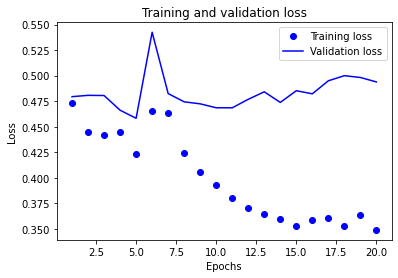

In [137]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#"bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
#b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

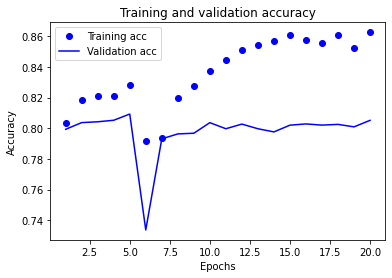

In [138]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CNN 모델

In [139]:
vocab_size = len(word_to_index)     # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 300  # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [140]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 23s 10ms/step - loss: 0.4436 - accuracy: 0.7847 - val_loss: 0.3429 - val_accuracy: 0.8506
Epoch 2/20
227/227 [==============================] - 2s 8ms/step - loss: 0.3014 - accuracy: 0.8741 - val_loss: 0.3318 - val_accuracy: 0.8550
Epoch 3/20
227/227 [==============================] - 2s 8ms/step - loss: 0.2359 - accuracy: 0.9080 - val_loss: 0.3520 - val_accuracy: 0.8520
Epoch 4/20
227/227 [==============================] - 2s 8ms/step - loss: 0.1620 - accuracy: 0.9413 - val_loss: 0.4042 - val_accuracy: 0.8435
Epoch 5/20
227/227 [==============================] - 2s 8ms/step - loss: 0.1030 - accuracy: 0.9645 - val_loss: 0.4832 - val_accuracy: 0.8414
Epoch 6/20
227/227 [==============================] - 2s 8ms/step - loss: 0.0664 - accuracy: 0.9780 - val_loss: 0.5793 - val_accuracy: 0.8341
Epoch 7/20
227/227 [==============================] - 2s 8ms/step - loss: 0.0460 - accuracy: 0.9847 - val_loss: 0.6525 - val_accuracy: 0.8378
Epoc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


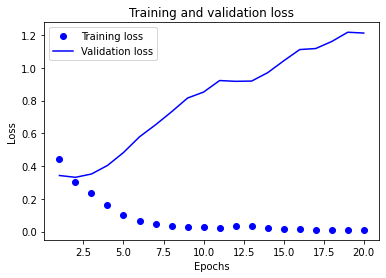

In [141]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#"bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
#b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

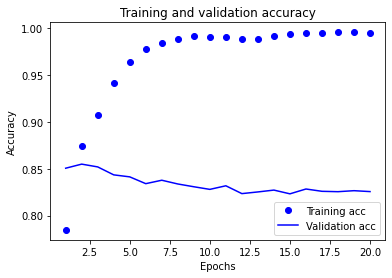

In [142]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [171]:
vocab_size = 10000 # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 300  # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 2408      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [172]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 2s 6ms/step - loss: 0.4606 - accuracy: 0.8107 - val_loss: 0.3453 - val_accuracy: 0.8495
Epoch 2/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3090 - accuracy: 0.8707 - val_loss: 0.3328 - val_accuracy: 0.8559
Epoch 3/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2598 - accuracy: 0.8953 - val_loss: 0.3417 - val_accuracy: 0.8538
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2153 - accuracy: 0.9171 - val_loss: 0.3562 - val_accuracy: 0.8547
Epoch 5/20
227/227 [==============================] - 1s 5ms/step - loss: 0.1679 - accuracy: 0.9402 - val_loss: 0.3877 - val_accuracy: 0.8507
Epoch 6/20
227/227 [==============================] - 1s 5ms/step - loss: 0.1219 - accuracy: 0.9613 - val_loss: 0.4209 - val_accuracy: 0.8493
Epoch 7/20
227/227 [==============================] - 1s 6ms/step - loss: 0.0822 - accuracy: 0.9766 - val_loss: 0.4623 - val_accuracy: 0.8482
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


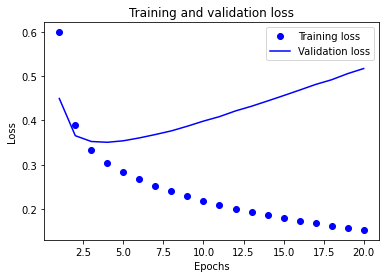

In [145]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#"bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
#b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

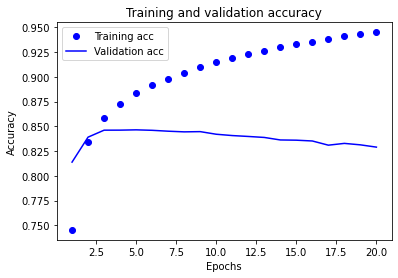

In [146]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [199]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

(10000, 300)


9

In [200]:
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [201]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['끝']
vector

array([ 5.95679402e-01,  2.35719219e-01,  2.06785396e-01,  4.32376772e-01,
        2.20692143e-01,  7.46285141e-01,  4.71730143e-01,  6.01203263e-01,
        6.38133764e-01,  1.38459504e-01,  7.15637267e-01,  8.02749991e-01,
        7.32263684e-01,  5.29984355e-01,  1.03352353e-01,  4.88815121e-02,
        3.86848807e-01,  4.29780781e-01,  7.14621395e-02,  2.69710124e-01,
        6.93507850e-01,  2.10150808e-01,  8.31912339e-01,  1.04812227e-01,
        6.45509839e-01,  3.29559803e-01,  2.78036028e-01,  9.34461534e-01,
        5.74716628e-01,  4.71785992e-01, -2.06283629e-02,  4.30420876e-01,
        3.95537317e-01,  7.07505643e-01,  7.68618345e-01,  3.99549305e-01,
        8.47204864e-01,  8.11433136e-01,  6.26720011e-01,  9.54889804e-02,
        9.48003650e-01,  9.54764843e-01,  1.35771438e-01,  3.83648962e-01,
        5.74098051e-01,  4.30610001e-01,  4.08396482e-01,  7.09244668e-01,
        7.45363116e-01,  3.99268597e-01,  1.68669581e-01,  3.51246834e-01,
        4.25140291e-01,  

In [202]:
word_vectors

## 단어 비교 word_vector와 korea 버전

In [180]:
word_vectors.similar_by_word("love")

[('멋져요', 0.5344921350479126),
 ('위력', 0.5274861454963684),
 ('부드럽', 0.5171400308609009),
 ('고마워요', 0.5091816186904907),
 ('김민희', 0.5078940391540527),
 ('.♥', 0.505643367767334),
 ('^^~', 0.49326735734939575),
 ('크리스틴', 0.48772817850112915),
 ('아름다워요', 0.4847925305366516),
 ('넘침', 0.4841049015522003)]

In [11]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME') + "/data/word2vec_ko.model"

word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv["끝"]

In [23]:
word_vectors.wv.similar_by_word("잠")

[('낮잠', 0.7209728956222534),
 ('깨어나', 0.6985119581222534),
 ('늦잠', 0.6658555865287781),
 ('한숨', 0.6528148055076599),
 ('하룻밤', 0.6330604553222656),
 ('노숙', 0.6213618516921997),
 ('도망가', 0.6158702373504639),
 ('깨어났', 0.613922655582428),
 ('겨울잠', 0.6007667779922485),
 ('감방', 0.5990805625915527)]

## 비교시에 비율이 한국어로 진행한 것이 0.2 가까이 높게 나와 정확도가 더 좋다. 

In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)


for i in range(4,vocab_size):

    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

## RNN

In [15]:
from tensorflow.keras.initializers import Constant
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,042,769
Trainable params: 1,042,769
Non-trainable params: 0
_________________________________________________________________


In [16]:
# validation set 10000건 분리
x_val = x_train[:28000]   
y_val = y_train[:28000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[28000:]  
partial_y_train = y_train[28000:]


print(partial_x_train.shape)
print(partial_y_train.shape)

(118182, 41)
(118182,)


In [17]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
1847/1847 [==============================] - 21s 6ms/step - loss: 0.4194 - accuracy: 0.8039 - val_loss: 0.3475 - val_accuracy: 0.8453
Epoch 2/3
1847/1847 [==============================] - 10s 5ms/step - loss: 0.3160 - accuracy: 0.8624 - val_loss: 0.3216 - val_accuracy: 0.8587
Epoch 3/3
1847/1847 [==============================] - 10s 5ms/step - loss: 0.2779 - accuracy: 0.8829 - val_loss: 0.3246 - val_accuracy: 0.8616


In [18]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3329 - accuracy: 0.8592
[0.3329308032989502, 0.8591655492782593]



---

------------------------------------------------------

# 회고
 글자의 데이터를 가지고 유사도를 측정한다는 자연어처리 프로젝트였는데 역시나 어려웠다..그래도 여러 모델의 다양한 옵션값 설정에 따른 변화와 그 변화를 시각화하여 볼 수 있었으며 validation set의 갯수에 따라 비율이 바뀌는 것을 확인 할 수 있었다. 적당한 파라미터 값을 찾는 일은 아직도 어려운거 같다. 마지막으로 word vector를 이용한 방법에서 높은 정확도가 나오는것을 확인 할 수 있었고 단어의 유사도 또한 한국버전을 쓰는것이 높은 것을 확인했다. 주말에 좀더 연습해봐야할거 같다. 